In [95]:
import pandas as pd
import numpy as np
import random as rand

import matplotlib.pyplot as plt
from collections import Counter 
import textwrap

In [203]:
# read in data
# make sure filename is whatever the name of the file is in your directory
filename = 'EyeGEx_retina.counts.matrix.gct'
fullExpressionData = pd.read_csv(filename, header=2, delim_whitespace=True)
print(fullExpressionData.head())

              NAME Description   100_2  101_3  102_2  103_3  104_2  105_2   
0  ENSG00000000003      TSPAN6  225.00  252.0  136.0  166.0  207.0  121.0  \
1  ENSG00000000005        TNMD    0.00    0.0    1.0    4.0    0.0    0.0   
2  ENSG00000000419        DPM1  254.00  301.0  173.0  264.0  307.0  140.0   
3  ENSG00000000457       SCYL3  422.99  510.0  272.0  301.0  417.0  116.0   
4  ENSG00000000460    C1orf112  272.00  310.0  204.0  224.0  227.0  149.0   

   106_4  107_4  ...   90_2   91_2   92_3  93_2   94_4   95_4   96_3   97_2   
0  127.0  304.0  ...  132.0  149.0  186.0  71.0  272.0  136.0  324.0  158.0  \
1    0.0    0.0  ...    0.0    0.0    3.0   1.0    1.0    1.0    1.0    2.0   
2  164.0  279.0  ...  369.0  148.0  265.0  86.0  326.0  283.0  300.0  242.0   
3  198.0  278.0  ...  274.0  163.0  227.0  96.0  418.0  338.0  277.0  342.0   
4  253.0  171.0  ...  280.0  168.0  308.0  86.0  284.0  260.0  179.0  210.0   

    98_3   99_1  
0  168.0  167.0  
1    1.0    0.0  
2  286.0

In [97]:
# to get genes of interest, remove zero genes first and then can find index from that subset of genes to look at and compare to index cluster list later
# remove genes (cols) where expression in all samples is 0
zeroGenes = (fullExpressionData.iloc[:, 2:] == 0).all(axis=1)
filteredData = fullExpressionData.loc[~zeroGenes, :]
filteredData = filteredData.reset_index(drop=True)
print(filteredData.shape)

(45297, 455)


In [204]:
# remove name and description columns so just left with data
expressionData = filteredData.drop(columns=['NAME','Description'])
print(expressionData.head())

    100_2  101_3  102_2  103_3  104_2  105_2  106_4  107_4  109_1   11_4  ...   
0  225.00  252.0  136.0  166.0  207.0  121.0  127.0  304.0  227.0  224.0  ...  \
1    0.00    0.0    1.0    4.0    0.0    0.0    0.0    0.0    4.0    0.0  ...   
2  254.00  301.0  173.0  264.0  307.0  140.0  164.0  279.0  216.0  274.0  ...   
3  422.99  510.0  272.0  301.0  417.0  116.0  198.0  278.0  243.0  297.0  ...   
4  272.00  310.0  204.0  224.0  227.0  149.0  253.0  171.0  274.0  198.0  ...   

    90_2   91_2   92_3  93_2   94_4   95_4   96_3   97_2   98_3   99_1  
0  132.0  149.0  186.0  71.0  272.0  136.0  324.0  158.0  168.0  167.0  
1    0.0    0.0    3.0   1.0    1.0    1.0    1.0    2.0    1.0    0.0  
2  369.0  148.0  265.0  86.0  326.0  283.0  300.0  242.0  286.0  207.0  
3  274.0  163.0  227.0  96.0  418.0  338.0  277.0  342.0  343.0  140.0  
4  280.0  168.0  308.0  86.0  284.0  260.0  179.0  210.0  225.0  124.0  

[5 rows x 453 columns]


In [143]:
# mean center the data and scale by variance so each gene has Gaussian distribution of values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(expressionData.T)
normalizedData = scaler.transform(expressionData.T)
normalizedData = normalizedData.T
print(normalizedData.shape)
print('mean: ',normalizedData.mean(axis=1))
print('std: ',normalizedData.std(axis=1))

(45297, 453)
mean:  [-2.55375804e-16 -4.82322056e-16  2.20329029e-16 ...  1.72706465e-17
  1.22541173e-17  1.00728844e-16]
std:  [1. 1. 1. ... 1. 1. 1.]


In [100]:
# efficient KMeans clustering
def FasterKMeans(data, k, convergence_threshold = 0.05):
    """
    Takes input data and runs K means clustering based on rows until convergence or threshold met; limited to 100 iterations since
    this is enough to observe approximate convergence at higher k values
    Input: data matrix, k (number of clusters/centroids)
    Output: cluster assignments (list), centroids/means (matrix), list of objective function values

    """
    # Randomly initialize k centroids
    centroids = data[np.random.choice(data.shape[0], k, replace=False), :]
    
    # Keep track of the previous centroids to check for convergence
    prev_centroids = None
    
    # Initialize objective function list
    objList = []
    iteration = 0

    # Run k-means until convergence
    while iteration < 100:
        # Assign each sample to the closest centroid
        distances = np.linalg.norm(data[:, np.newaxis, :] - centroids, axis=-1)
        cluster_assignment = np.argmin(distances, axis=1)
        
        # Update centroids based on the samples assigned to each cluster
        for cluster in range(k):
            centroids[cluster] = np.mean(data[cluster_assignment == cluster], axis=0)
        
        # Calculate objective function
        objList += [KMeansObjective(data, cluster_assignment, centroids)]

        # Check for convergence
        if prev_centroids is not None and np.max(np.abs(centroids - prev_centroids)) < convergence_threshold: 
            print("Converged")
            break

        if iteration > 100:
            print('Approximate convergence')
            break
            
        prev_centroids = centroids.copy()
        iteration += 1
        #print('Iteration ', iteration)
    
    return cluster_assignment, centroids, objList

def KMeansObjective(x, clusters, means):
    return ((x - means[clusters,:])**2).sum()

In [101]:
# run with various k sizes
k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
final_objs = []
for k in k_list:
    print('K means for K = ', k)
    # run it 5 times for each k and take the version with the best objective value
    for i in range(5):
        print('Running iteration', i)
        clusters, means, objs = FasterKMeans(normalizedData,k)
        if objs[len(objs)-1] < minObj or i == 0:
            print('New best found!')
            bestObjs = objs
            minObj = bestObjs[len(bestObjs)-1]
            bestClusters = clusters
            bestMeans = means

    final_objs.append(minObj)

K means for K =  2
Running iteration 0
Converged
New best found!
Running iteration 1
Converged
Running iteration 2
Converged
New best found!
Running iteration 3
Converged
Running iteration 4
Converged
K means for K =  3
Running iteration 0
Converged
New best found!
Running iteration 1
Converged
New best found!
Running iteration 2
Converged
New best found!
Running iteration 3
Converged
Running iteration 4
Converged
K means for K =  4
Running iteration 0
Converged
New best found!
Running iteration 1
Converged
New best found!
Running iteration 2
Converged
Running iteration 3
Converged
Running iteration 4
Converged
New best found!
K means for K =  5
Running iteration 0
Converged
New best found!
Running iteration 1
Converged
Running iteration 2
Converged
Running iteration 3
Converged
Running iteration 4
Converged
K means for K =  6
Running iteration 0
Converged
New best found!
Running iteration 1
Converged
Running iteration 2
Converged
Running iteration 3
Converged
Running iteration 4
Conve

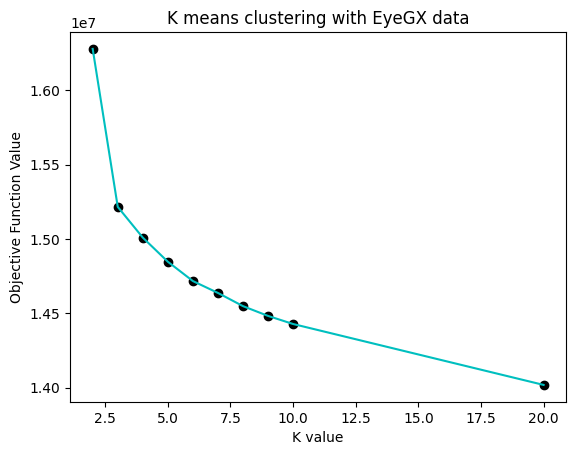

In [102]:
# plot objective function (y) vs K (x)
plt.figure(0)
plt.plot(k_list, final_objs, color = 'c')
plt.scatter(k_list, final_objs, color = 'k')
plt.title("K means clustering with EyeGX data")
plt.xlabel("K value")
plt.ylabel("Objective Function Value")
plt.show()

In [144]:
# take optimal k and data and perform K means clustering
k = 3
minObj = 0
# run it 10 times and take the version with the best objective value
for i in range(10):
    clusters, means, objs = FasterKMeans(normalizedData,k)
    if objs[len(objs)-1] < minObj or i == 0:
        print('New best found on iteration', i)
        bestObjs = objs
        minObj = bestObjs[len(bestObjs)-1]
        bestClusters = clusters
        bestMeans = means

Converged
New best found on iteration 0
Converged
Converged
New best found on iteration 2
Converged
Converged
Converged
New best found on iteration 5
Converged
Converged
Converged
Converged


In [145]:
print(bestClusters.shape)
print(bestMeans.shape)

(45297,)
(3, 453)


In [197]:
# now get index of genes of interest using filteredData which still has name and description as headers
#print(filteredData.loc[7:20])
geneList = ['B3GLCT', 'BLOC1S1', 'RP11-644F5.10', 'CTA-228A9.3', 'SH2B3', 'MEPCE', 'PMS2P1', 'STAG3L5P-PVRIG2P-PILRB', 'PILRB', 'TMEM199', 'POLDIP2', 'CFI', 'PLA2G12A', 'ANAPC11', 'SKIV2L', 'HERPUD1', 'TOMM70', 'KCNT2', 'TMEM229B', 'PLTP', 'ARMS2', 'HTRA1']
indexList = []
for i in range(len(geneList)):
    indices = filteredData.index[filteredData.iloc[:, 1] == geneList[i]].tolist()
    if len(indices) != 1:
        print('More than 1 occurrence of gene', geneList[i])
    else: 
        indexList.append(indices[0])


print(indexList)
print(len(indexList))
print(len(geneList))

[16174, 7029, 35294, 41182, 3844, 8823, 1414, 41198, 5157, 30435, 47, 18633, 5388, 8074, 18315, 685, 9657, 10709, 17259, 2405, 33676, 11650]
22
22


In [198]:
# get cluster assigment of genes of interest
assignmentList = []
for i in range(len(indexList)):
    assignment = bestClusters[indexList[i]]
    assignmentList.append(assignment)

print(assignmentList)

[2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 1, 0, 0, 1, 0]


In [205]:
# count the frequency of each integer in the list
count_dict = Counter(assignmentList)

# store the proportion of each integer in the list in a dict
prop_dict = {k: v / len(assignmentList) for k, v in count_dict.items()}

# print the results
print(prop_dict)

{2: 0.4090909090909091, 0: 0.5, 1: 0.09090909090909091}


In [206]:
# create dict mapping gene and cluster assignment
sc_dict = dict(zip(geneList, assignmentList))
print(sc_dict)

# create a dict of genes in each cluster
strings_by_cluster = {}
for string, cluster_label in sc_dict.items():
    if cluster_label not in strings_by_cluster:
        strings_by_cluster[cluster_label] = []
    strings_by_cluster[cluster_label].append(string)

print('strings by cluster:', strings_by_cluster)

{'B3GLCT': 2, 'BLOC1S1': 0, 'RP11-644F5.10': 0, 'CTA-228A9.3': 2, 'SH2B3': 2, 'MEPCE': 0, 'PMS2P1': 2, 'STAG3L5P-PVRIG2P-PILRB': 0, 'PILRB': 0, 'TMEM199': 2, 'POLDIP2': 0, 'CFI': 2, 'PLA2G12A': 2, 'ANAPC11': 0, 'SKIV2L': 0, 'HERPUD1': 2, 'TOMM70': 2, 'KCNT2': 1, 'TMEM229B': 0, 'PLTP': 0, 'ARMS2': 1, 'HTRA1': 0}
strings by cluster: {2: ['B3GLCT', 'CTA-228A9.3', 'SH2B3', 'PMS2P1', 'TMEM199', 'CFI', 'PLA2G12A', 'HERPUD1', 'TOMM70'], 0: ['BLOC1S1', 'RP11-644F5.10', 'MEPCE', 'STAG3L5P-PVRIG2P-PILRB', 'PILRB', 'POLDIP2', 'ANAPC11', 'SKIV2L', 'TMEM229B', 'PLTP', 'HTRA1'], 1: ['KCNT2', 'ARMS2']}


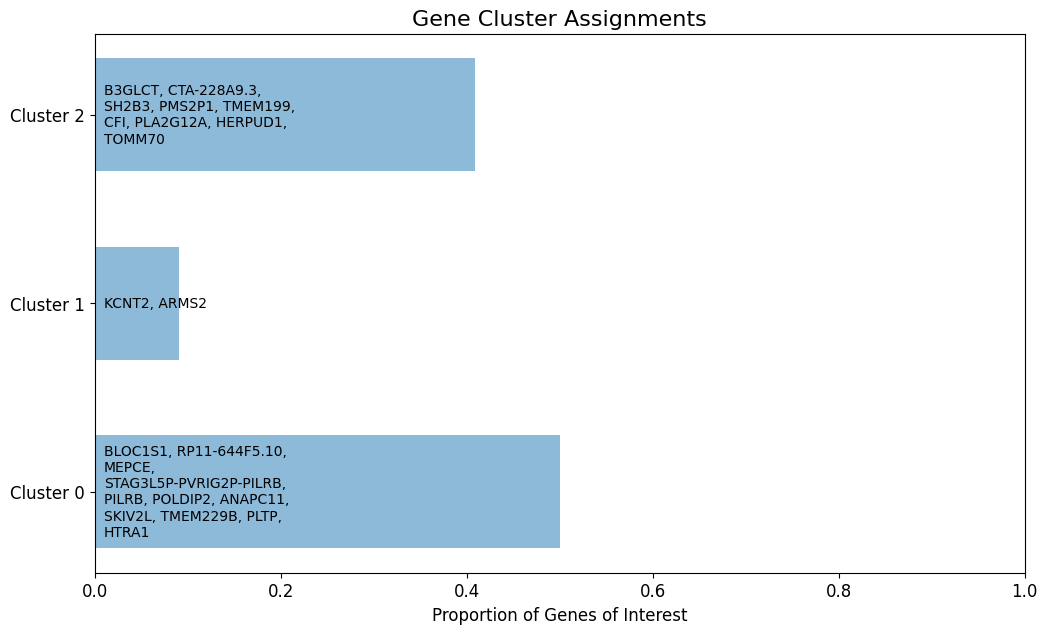

In [201]:
# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 7))

# set the y-axis labels to the cluster labels
ax.set_yticks(list(prop_dict.keys()))
ax.set_yticklabels([f'Cluster {label}' for label in prop_dict])

# set the x-axis limits to [0, 1]
ax.set_xlim([0, 1])

# plot the proportion of genes from list in each cluster
ax.barh(list(prop_dict.keys()), list(prop_dict.values()), height=0.6, color='C0', alpha=0.5)

max_width = 25
# add the list of genes for each cluster
for cluster_label, strings in strings_by_cluster.items():
    string_list = ', '.join(strings)
    
    # wrap the list 
    wrapped_lines = textwrap.wrap(string_list, width=max_width)

    # combine the wrapped lines into a single string, with newline characters in between
    wrapped_text = '\n'.join(wrapped_lines)

    ax.text(0.01, cluster_label, wrapped_text, va='center', fontsize=10)

# add a title and labels
ax.set_title('Gene Cluster Assignments', fontsize=16)
ax.set_xlabel('Proportion of Genes of Interest', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

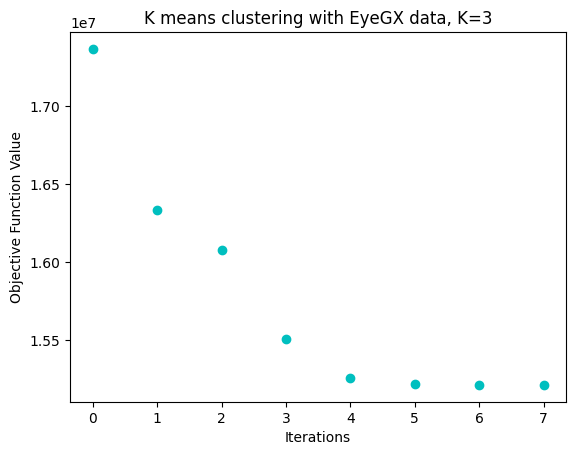

In [202]:
# plot objective function (y) vs iterations (x)
xValues = list(range(len(objs)))
plt.figure(1)
plt.scatter(xValues, objs, color = 'c', label = 'Objective Values')
plt.title("K means clustering with EyeGX data, K=3")
plt.xlabel("Iterations")
plt.ylabel("Objective Function Value")
plt.show()